In [4]:
import jax
from jax import numpy as jnp
from jax import random

In [5]:
# generate metrix [[0, b, ba, ba^2, ..., ba^H-1], [0,0,b,ba, ..., ba^H-2], ...]
def generate_matrix(a, b, H):
    matrix = jnp.zeros((H+1, H))
    for i in range(1, H+1):
        for j in range(0, i):
            # matrix = jax.ops.index_update(matrix, jax.ops.index[i, j], b * a ** (j - i))
            matrix = matrix.at[i, j].set(b * a ** (i -1 - j))
    return matrix

# refine parallel test function

In [1]:
import jax.numpy as jnp
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_hyperplane

def get_sigma_eign(eign_values, lam, H, sig):
    # Objective function
    def objective(params):
        return jnp.sum(eign_values/(1+2/lam*eign_values*jnp.exp(params))**2)

    # Constraint: x1 + x2 = 1, represented as a hyperplane
    def projection_fn(params, hyperparams_proj):
        return projection_hyperplane(params, hyperparams=(hyperparams_proj, H*jnp.log(sig)))

    # Initialize 'ProjectedGradient' solver
    solver = ProjectedGradient(fun=objective, projection=projection_fn)

    # Initial parameters
    params_init = jnp.ones(H) * 0.0

    # Define the optimization problem
    sol = solver.run(params_init, hyperparams_proj=jnp.ones(H))

    # verify the solution
    o = eign_values
    s = jnp.exp(sol.params)
    cc = ((o**2)*s)/((1+2/lam*o*s)**3)

    # Print the optimal solution
    print("Optimal Solution: ", sol.params)

    return jnp.exp(sol.params)

def get_sigma_eign2(eign_values, lam, H, sig):
    log_o = jnp.log(eign_values)
    log_const = 2 * H * jnp.log(sig) + jnp.sum(log_o)
    log_s = 0.5 * log_const - 0.5 * log_o

    o = eign_values
    s = jnp.exp(log_s)
    cc = ((o**2)*s)/((1+2/lam*o*s)**3)
    print('verified solution: ', cc)

    return s

In [ ]:
def test_once(H = 3, sig = 0.5, lam = 0.01):
    N=8192
    AB_matrix = generate_matrix(1.0, 1.0, H)
    Q_matrix = jnp.eye(H+1) * 1.0

    a_cov = jnp.eye(H)*sig

    # R = AB_matrix.T @ Q_matrix @ AB_matrix
    # u, s, vh = jnp.linalg.svd(R)
    # sigma_eign = get_sigma_eign2(s, lam, H, sig)
    # a_cov = vh.T @ jnp.diag(sigma_eign) @ vh

    # # a_cov = jnp.linalg.inv(2/lam*R)
    # print(R)
    # print(a_cov)
    # print(jnp.linalg.det(a_cov))

    def dynamic_fn(x, action):
        # x = jnp.clip(0.9*x + 0.4 * jnp.clip(action, -1.0, 1.0), -2, 2)
        x = 1.0*x + action
        return x
    
    def reward_fn(t, x):
        x_tar = jnp.sin(0.6*t)
        reward = 1.0-jnp.abs(x - x_tar)
        return reward

    def get_next_a_mean(t, x, a_mean, rng):
        # shift a_mean to the left by 1 and append the last element
        a_mean = jnp.concatenate([a_mean[1:], a_mean[-1:]])

        rng_act, rng = random.split(rng)
        # sample actions with a_mean and a_cov
        a_sampled = jax.vmap(lambda rng: random.multivariate_normal(rng, a_mean, a_cov))(random.split(rng, N)) # (N, H)

        def rollout_fn(carry, action):
            t, x = carry
            x = dynamic_fn(x, action)
            t = t + 1
            reward = reward_fn(t, x)
            return (t, x), reward

        xx = jnp.repeat(x, N)
        tt = jnp.repeat(t, N)
        _, reward = jax.lax.scan(rollout_fn, (tt, xx), a_sampled.T)

        cost = -jnp.sum(reward, axis=0)
        cost_exp = jnp.exp(-(cost-jnp.min(cost)) / lam)
        weight = cost_exp / jnp.sum(cost_exp)

        a_mean = jnp.sum(a_sampled * weight[:, None], axis=0)

        return a_mean, rng

    def step_env(carry, unused):
        t, x, a_mean, rng = carry
        a_mean, rng = get_next_a_mean(t, x, a_mean, rng)
        action = a_mean[0]
        reward = reward_fn(t, x)
        x = dynamic_fn(x, action)
        t = t + 1
        return (t, x, a_mean, rng), (x, reward)


    def run_exp_once(rng):
        x0 = 1.0
        t0 = 0
        a_mean = jnp.zeros(H)
        carry = (t0, x0, a_mean, rng)
        _, (x, reward) = jax.lax.scan(step_env, carry, jnp.arange(30))
        return reward.mean()

    rng = random.PRNGKey(0)
    # run experiment for 4096 times
    rewards = jax.vmap(jax.jit(run_exp_once))(random.split(rng, 4096))

    return rewards.mean(), rewards.std()

# test once

In [6]:
test_once(H=3, lam=0.01)

verified solution:  [7.5875319e-06 6.9130856e-06 6.4924920e-06]
[[3. 2. 1.]
 [2. 2. 1.]
 [1. 1. 1.]]
[[ 0.10888994 -0.06042938 -0.01078347]
 [-0.06042938  0.15853584 -0.04964587]
 [-0.01078347 -0.04964587  0.16931924]]
0.0019531264


(Array(0.9587711, dtype=float32), Array(0.00118285, dtype=float32))

# multiple test

In [ ]:
Hs = jnp.power(2, jnp.arange(0, 8))
sigs = jnp.linspace(0.1, 1.0, 10)
means = []
stds = []
for sig in sigs:
    mean, std = test_once(sig=sig)
    means.append(mean)
    stds.append(std)

In [ ]:
# plot results with error bars
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.errorbar(sigs, means, yerr=stds, fmt='o')
# plt.xlabel('log horizon')
plt.ylabel('average reward')

# plot control sequence

(8,) ()
(8,) ()
(8,) ()


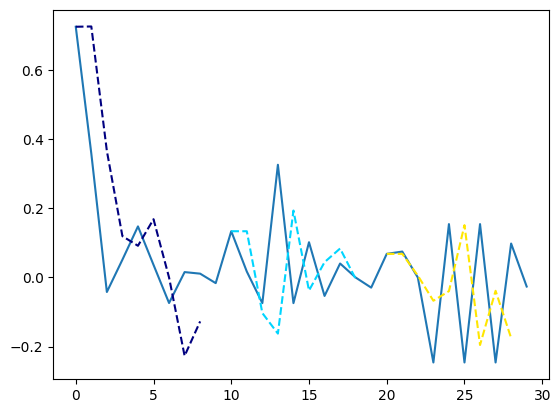

In [5]:
import jax
from jax import numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as sns

N = 128
H = 8
a_cov = jnp.eye(H)*0.5
lam = 0.1 #0.03

def dynamic_fn(x, action):
    x = jnp.clip(1.0 * x + 0.4 * jnp.clip(action, -1.0, 1.0), -2, 2)
    return x

def reward_fn(x):
    reward = 1.0-jnp.abs(x)
    return reward

def get_next_a_mean(x, a_mean, rng):
    # shift a_mean to the left by 1 and append the last element
    a_mean = jnp.concatenate([a_mean[1:], a_mean[-1:]])

    rng_act, rng = random.split(rng)
    # sample actions with a_mean and a_cov
    a_sampled = jax.vmap(lambda rng: random.multivariate_normal(rng, a_mean, a_cov))(random.split(rng, N)) # (N, H)

    def rollout_fn(carry, action):
        x = carry
        x = dynamic_fn(x, action)
        reward = reward_fn(x)
        return x, (reward, x)

    xx = jnp.repeat(x, N)
    _, (reward, x_sampled) = jax.lax.scan(rollout_fn, xx, a_sampled.T)

    cost = -jnp.sum(reward, axis=0)
    cost_exp = jnp.exp(-(cost-jnp.min(cost)) / lam)
    weight = cost_exp / jnp.sum(cost_exp)

    a_mean = jnp.sum(a_sampled * weight[:, None], axis=0)

    x_mean = jnp.sum(x_sampled.T * weight[:, None], axis=0)

    return a_mean, rng, x_sampled, x_mean

def step_env(carry, unused):
    x, a_mean, rng = carry
    a_mean, rng, x_sampled, x_mean = get_next_a_mean(x, a_mean, rng)
    action = a_mean[0]
    reward = reward_fn(x)
    x = dynamic_fn(x, action)
    return (x, a_mean, rng), (x, reward, x_sampled, x_mean)

x0 = 1.0
a_mean = jnp.zeros(H)
carry = (x0, a_mean, random.PRNGKey(2))
_, (x, reward, x_sampled, x_mean) = jax.lax.scan(step_env, carry, jnp.arange(30))

plt.plot(x)
for i in range(0, 30, 10):
    t = jnp.arange(i, i+H+1)
    print(x_mean[i].shape, x[i].shape)
    mean = jnp.concatenate([jnp.array([x[i]]), x_mean[i]])
    plt.plot(t, mean, '--', alpha=1.0, color=plt.cm.jet(i/30))
    # for j in range(N):
    #     sampled = x_sampled[i, :, j]
    #     sampled = jnp.concatenate([jnp.array([x[i]]), sampled])
    #     # set color related to i
    #     plt.plot(t, sampled, '--', alpha=0.5, color=plt.cm.jet(i/30))